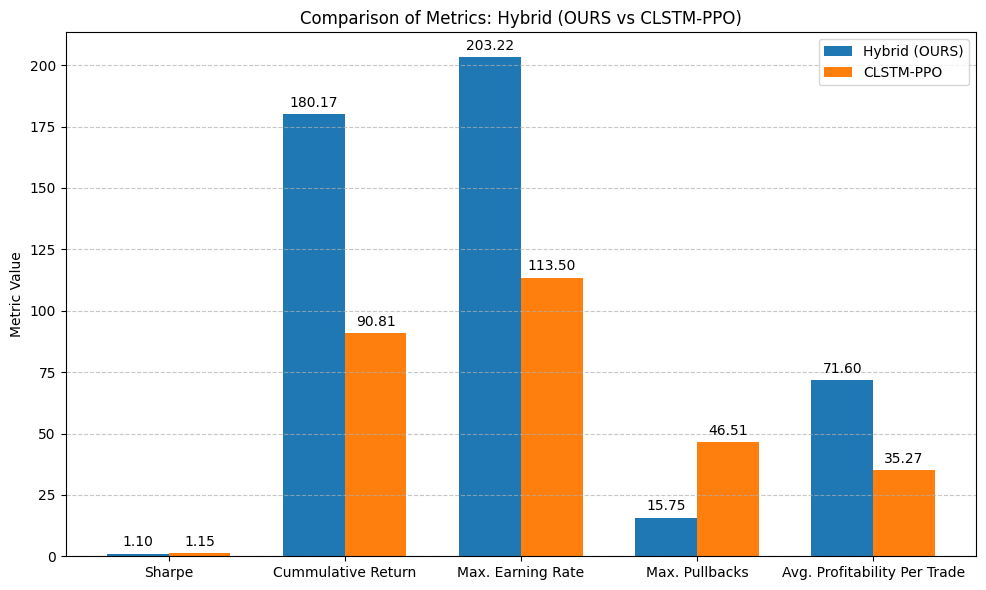

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data
metrics = ['Sharpe', 'Cummulative Return', 'Max. Earning Rate', 'Max. Pullbacks', 'Avg. Profitability Per Trade']
ours = [1.099, 180.17, 203.22, 15.75, 71.6]
clstm = [1.1540, 90.81, 113.50, 46.51, 35.27]

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, ours, width, label='Hybrid (OURS)')
bars2 = ax.bar(x + width/2, clstm, width, label='CLSTM-PPO')

# Labels and titles
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Metrics: Hybrid (OURS vs CLSTM-PPO)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add value labels on top
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import scipy.special

def calculate_compound_scores(probabilities):
    return probabilities['positive'] - probabilities['negative']

def get_news_sentiment(df, batch_size=32):
    # Combine Title and Description
    combined_texts = (df["Title"].astype(str).str.strip() + ". " + df["Description"].astype(str).str.strip()).tolist()

    # Load FinBERT
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    model.eval()

    # Store scores
    compound_scores = []
    labels = list(model.config.id2label.values())

    # Process in batches
    for i in range(0, len(combined_texts), batch_size):
        batch_texts = combined_texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            logits = model(**inputs).logits

        probs = scipy.special.softmax(logits.numpy(), axis=1)

        for row in probs:
            scores = {labels[j]: row[j] for j in range(len(labels))}
            score = calculate_compound_scores(scores)
            compound_scores.append(float(score))

    print("[✅ Sentiment scores calculated in batches]")
    return compound_scores


In [2]:
import pandas as pd

# Load your cleaned CSV
df = pd.read_csv("/content/IndianFinancialNews.csv")

# Compute sentiment scores (using your batched FinBERT function)
df['Sentiment Score'] = get_news_sentiment(df, batch_size=32)

# Save to a new CSV including Date and Sentiment Score
df.to_csv("IndianFinancialNews_Sentiment.csv", index=False)

print("✅ Sentiment scores added and saved to 'news_with_sentiment.csv'")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

[✅ Sentiment scores calculated in batches]
✅ Sentiment scores added and saved to 'news_with_sentiment.csv'


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import sys

def stocks_data(ticker: str, start_date: str, end_date: str):


    # to get all about "ticker"
    stock = yf.Ticker(ticker)

    # get history data of the stock (already in pandas DataFrame)
    data_raw = stock.history(start=start_date, end=end_date)

    # remove unncessary columns ['Dividends', 'Stock Splits']
    data_raw = data_raw.drop(['Dividends', 'Stock Splits'], axis=1)

    # calculating and defining other stock metrics [EMA_12, EMA_26, MACD, Signal, RSI, CCI, ADX]

    """
    Definations:

    EMA_12 - 12 days Exponential Moving Average
    EMA_26 - 26 days Exponential Moving Average
    MACD - Moving Average Convergence and Divergence (difference of EMA_12 & EMA_26)
    Signal - 9 days EMA of MACD
    RSI - Relative Strength Index (14 days calulation)
    CCI- Used to identify overbought and oversold conditions
    ADX - Measures trend strength based on DMI (Directional Movement Index)

    """

    # calculating TP for CCI
    data_raw['TP'] = (data_raw['High'] + data_raw['Low'] + data_raw['Close']) / 3

    # 12 day & 26 day EMA for MACD
    data_raw['EMA_12'] = data_raw['Close'].ewm(span=12, adjust=False).mean()
    data_raw['EMA_26'] = data_raw['Close'].ewm(span=26, adjust=False).mean()
    data_raw['MACD'] = data_raw['EMA_12'] - data_raw['EMA_26']
    data_raw['Signal'] = data_raw['MACD'].ewm(span=9, adjust=False).mean()

    # RSI calculation
    delta = data_raw['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain/loss
    data_raw['RSI'] = 100 - (100/(1 + rs))

    # CCI calculation
    n = 14
    data_raw['SMA_TP'] = data_raw['TP'].rolling(n).mean()
    data_raw['MAD_TP'] = data_raw['TP'].rolling(n).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    data_raw['CCI'] = (data_raw['TP'] - data_raw['SMA_TP'])/(0.015 * data_raw['MAD_TP'])

    # ADX calculation
    data_raw['+DM'] = data_raw['High'].diff()
    data_raw['-DM'] = data_raw['Low'].diff()
    data_raw['+DM'] = np.where((data_raw['+DM'] > data_raw['-DM']) & (data_raw['+DM'] > 0), data_raw['+DM'], 0)
    data_raw['-DM'] = np.where((data_raw['-DM'] > data_raw['+DM']) & (data_raw['-DM'] > 0), data_raw['-DM'], 0)
    data_raw['TR'] = np.maximum(data_raw['High'] - data_raw['Low'], 
                                np.maximum(abs(data_raw['High'] - data_raw['Close'].shift(1)),
                                           abs(data_raw['Low'] - data_raw['Close'].shift(1))))
    data_raw['ATR'] = data_raw['TR'].rolling(n).mean()
    data_raw['+DI'] = (data_raw['+DM'].rolling(n).mean()/data_raw['ATR']) * 100
    data_raw['-DI'] = (data_raw['-DM'].rolling(n).mean()/data_raw['ATR']) * 100
    data_raw['DX'] = (abs(data_raw['+DI'] - data_raw['-DI'])/(data_raw['+DI'] + data_raw['-DI'])) * 100
    data_raw['ADX'] = data_raw['DX'].rolling(n).mean()


    # getting required data [Open, High, Low, Close, Volume, EMA_12, EMA_26, MACD, Signal, RSI, CCI, ADX]
    data_req = data_raw[['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_12', 'EMA_26', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]

    #print(f"Initial Length {len(data_req)}")

    # drop NaN rows as it could be better solution
    # data_req = data_req.dropna()

    # use bfill to save data
    data_req = data_req.bfill()

    #print(f"Present Length {len(data_req)}")

    return data_req


# for testing purpose

if __name__ == "__main__":
    tickers = dow_jones_tickers = [
            "^BSESN"
        ]
    # period = "10y"
    start_date = "2009-01-02"
    end_date = "2020-05-08"

    for ticker in tickers:
        data = stocks_data(ticker, start_date, end_date)
        data.to_csv(f"{ticker}_data.csv")



In [4]:
df1 = pd.read_csv("^BSESN_data.csv")
df1["Date"] = pd.to_datetime(df1["Date"], utc=True).dt.tz_convert("Asia/Kolkata").dt.date

# import sentiment data and convert dateformat
df2 = pd.read_csv("data/indian_sentiment_avg.csv")
df2["Publish Date"] = pd.to_datetime(df2["Publish Date"]).dt.date

# merge dataframes
df = pd.merge(df1, df2, left_on="Date", right_on="Publish Date")
df = df.drop("Publish Date", axis=1)
df.rename(columns={"Average": "Sentiment Average"}, inplace=True)

# rewrite existing csv file with additional changes
df.to_csv("^BSESN_data.csv", index=False)
